# SERD MEQ Data Analysis 

### This data analysis provide informations below:
1. Catalog Picking
2. Station data
3. Initial Hypocenter using NLL
4. Relocated Hypocenter (HypoDD non WCC and WCC)
6. Magnitude estimation

### 1. Catalog Picking

In [52]:
import numpy as np
import pandas as pd
import math
from pathlib import Path, PurePath
import plotly.graph_objects as go
import plotly.express as px
from collections import defaultdict as dfdict
from plotly.subplots import make_subplots

# load the excel file
raw_catalog = Path(r"E:\BACK UP KERJA\SUPREME ENERGY\SERD\SERD Catalog\SERD_MEQ_Catalog_updated.xlsx")
pd_catalog = pd.read_excel(raw_catalog, sheet_name = 'Catalog Picking', header = 2)
pd_catalog.head(8)

Event ID Station  Year  Month  Day  Hour  Minutes_P  P_Arr_Sec P_Polarity  \
0      2000    RD09  2024      3    6    12         49  47.379929          -   
1      2000    RD06  2024      3    6    12         49  47.705910          -   
2      2000    RD05  2024      3    6    12         49  48.029350          +   
3      2001    RD05  2024      3    9    13          9  39.826855          -   
4      2001    RD06  2024      3    9    13          9  39.921669          -   
5      2001    RD09  2024      3    9    13          9  40.029068          -   
6      2001    RD12  2024      3    9    13          9  40.273041          +   
7      2001    RD02  2024      3    9    13          9  40.292496          -   

  P_Onset  Minutes_S  S_Arr_Sec S_Polarity S_Onset     Ts_Tp  Minutes_T0  \
0       I         49  47.917015          ?       I  0.537086          49   
1       I         49  48.525749          ?       E  0.819839          49   
2       E         49  49.023460          ?       E  0.994110          49   
3       I          9  40.578003          ?       E  0.751148           9   
4       I          9  40.684307          ?       E  0.762638           9   
5       E          9  40.856537          ?       E  0.827469           9   
6       E          9  41.316063          ?       E  1.043022           9   
7       E          9  41.327335          ?       E  1.034839           9   

      T0_Sec  P Travel  S Travel      VpVs  
0  46.591812  0.788117  1.325203  1.703955  
1  46.591812  1.114098  1.933937  1.703955  
2  46.591812  1.437538  2.431648  1.703955  
3  38.840496  0.986359  1.737507  1.722454  
4  38.840496  1.081173  1.843811  1.722454  
5  38.840496  1.188572  2.016041  1.722454  
6  38.840496  1.432545  2.475567  1.722454  
7  38.840496  1.452000  2.486839  1.722454

#### a. Number of picks for each station

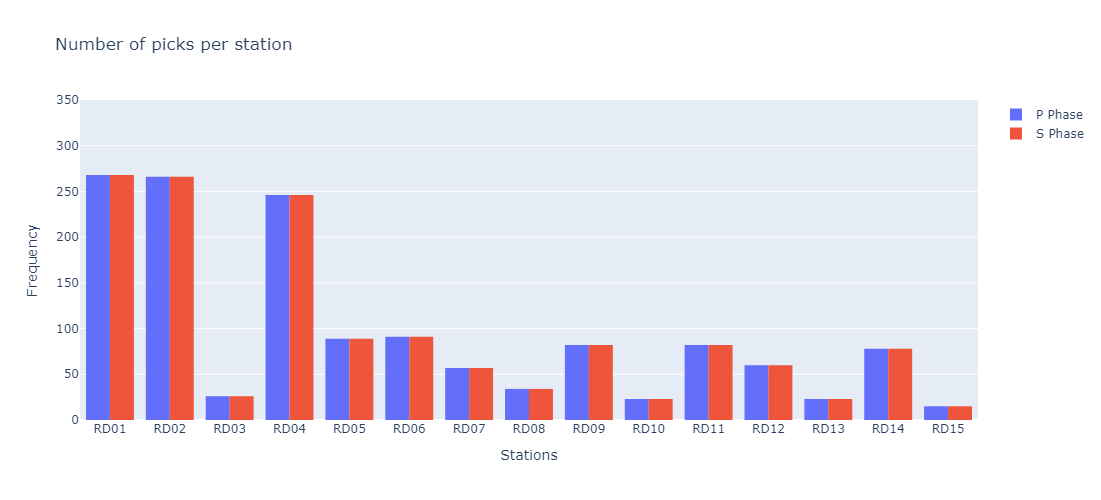

In [6]:
# load the data
stations = pd_catalog.Station
# list of station 
list_station = ['RD01','RD02','RD03','RD04','RD05','RD06','RD07','RD08','RD09','RD10','RD11','RD12','RD13','RD14','RD15']
# initialize an empty list dict
dio_P = dfdict(int)
dio_S = dfdict(int)
# create dict holder for all complete stations ==> dict structture {"ML01 P:"[total,weighting]}
for x in range(0, len(list_station)):
        dio_P[f"{list_station[x]}"] = 0
        dio_S[f"{list_station[x]}"] = 0
# calculate number of pick recorded by each station
for sta in stations:
    if sta in list_station:
        dio_P[f"{sta}"] += 1
        dio_S[f"{sta}"]+= 1
df_P = pd.DataFrame(list(dio_P.items()), columns = ["Stations", "Picks"])
df_S =  pd.DataFrame(list(dio_S.items()), columns = ["Stations", "Picks"])
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc = "sum", y= df_P.Picks, x= df_P.Stations, name = "P Phase"))
fig.add_trace(go.Histogram(histfunc = "sum", y= df_S.Picks, x= df_S.Stations, name = "S Phase"))
fig.update_layout(
    title = f"Number of picks per station",
    xaxis_title = f"Stations",
    yaxis_title = f"Frequency",
    yaxis = dict(range= [0,350]),
    height = 500)

#### b. Vp/Vs Profile from all picks data

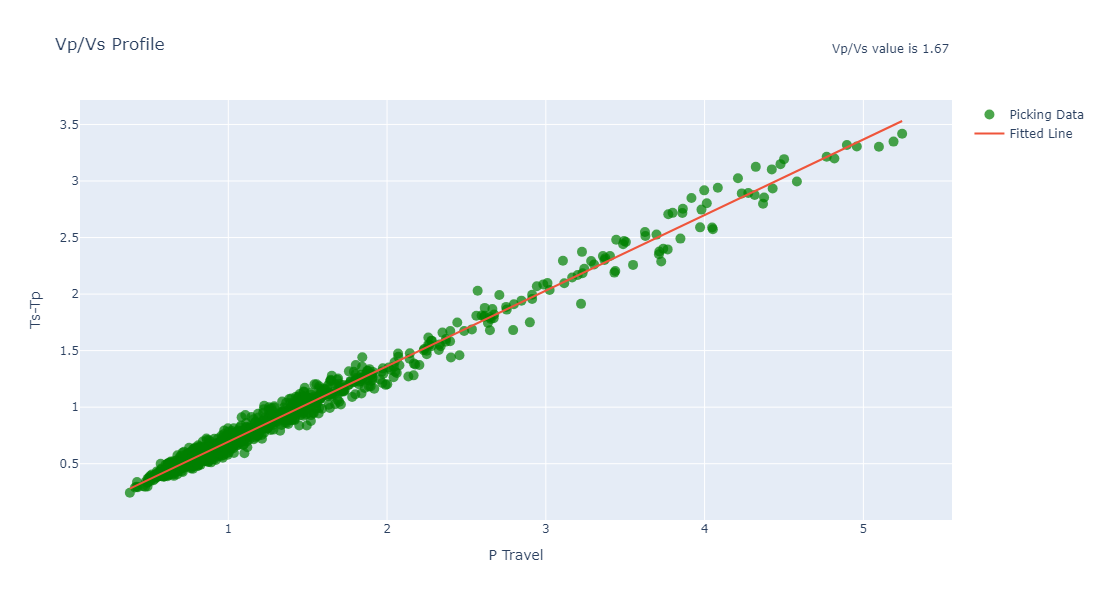

In [8]:
# create plot for Vp/Vs profile from all picks data
x_ = pd_catalog["P Travel"]
y_ = pd_catalog["Ts_Tp"]
fig1 = go.Figure()
fig1.add_trace(go.Scatter (x = x_, y = y_ , mode = 'markers',marker=dict(size=10, color='Green', opacity = 0.7 ),name = 'Picking Data'))
# create the fitting line
# Fit a linear regression model
coefficients = np.polyfit(x_, y_, 1)  # 1 for linear
slope, intercept = coefficients
# Generate fitted line data
x_fit = np.linspace(min(x_), max(x_), 100)
y_fit = slope * x_fit + intercept
fig1.add_trace(go.Scatter(x=x_fit, y=y_fit, mode='lines', name='Fitted Line'))
VpVs = 1 + slope
fig1.update_layout(
    title = f"Vp/Vs Profile",
    xaxis_title = 'P Travel',
    yaxis_title = 'Ts-Tp',
    width = 800,
    height = 600,
    annotations = [dict(x=1,y=1.1, text=f"Vp/Vs value is {VpVs:3.2f}",
            showarrow=False, xref='paper', yref='paper', xanchor='right', yanchor='bottom')])

### 2. Station Data

In [10]:
# load the stations data
station = Path(r"E:\BACK UP KERJA\SUPREME ENERGY\SERD\PETA RD\station.xlsx")
pd_station = pd.read_excel(station)
x_sta = pd_station.UTM_X
y_sta = pd_station.UTM_Y
sta_name = pd_station.STA
pd_station.head(5)

STA   UTM_X    UTM_Y  ELEV
0  RD01  323345  9536438  1504
1  RD02  322619  9534393  1753
2  RD03  321384  9534926  1899
3  RD04  324364  9534452  1719
4  RD05  320071  9535140  2013

### 3. Initial Hypocenter using NLL

In [12]:
# load the data and initiate the plotting 
pd_nll = pd.read_excel(raw_catalog, sheet_name = 'NLL detail statistic', header = 1)
x_nll = pd_nll['UTM X (m)']
y_nll = pd_nll['UTM Y (m)']
depth_nll = pd_nll['Depth (m)'] / 1000
pd_nll.head(8)

ID       Lat        Long   UTM X (m)    UTM Y (m)  Depth (m)  Elev (m)  \
0  2000.0 -4.242434  103.372212  319336.694  9530885.081  -1175.298  1175.298   
1  2001.0 -4.201381  103.357588  317703.629  9535421.371   1256.250 -1256.250   
2  2002.0 -4.201928  103.357587  317703.629  9535360.887   1369.345 -1369.345   
3  2003.0 -4.206831  103.348315  316675.403  9534816.532   1030.060 -1030.060   
4  2004.0 -4.233423  103.379041  320092.742  9531883.065  -2730.357  2730.357   
5  2005.0 -4.239546  103.364182  318444.556  9531202.621   -623.958   623.958   
6  2006.0 -4.240776  103.364043  318429.435  9531066.532   -327.083   327.083   
7  2007.0 -4.235994  103.365823  318626.008  9531595.766   -454.315   454.315   

     Year  Month   Day  Hour  Minute    OT(sec)  RMS error  N Phases      GAP  \
0  2024.0    3.0   6.0  12.0    49.0  46.546183   0.010690       6.0  321.498   
1  2024.0    3.0   9.0  13.0     9.0  38.734469   0.027836      12.0  282.688   
2  2024.0    3.0   9.0  13.0    10.0  42.207856   0.020810      10.0  281.314   
3  2024.0    3.0   9.0  22.0    47.0  51.342703   0.023819      12.0  284.371   
4  2024.0    3.0  10.0   7.0    38.0  55.681969   0.022159       8.0  297.885   
5  2024.0    3.0  11.0  19.0    39.0  56.085723   0.025351      14.0  160.259   
6  2024.0    3.0  11.0  19.0    40.0   4.796383   0.029251      16.0  152.590   
7  2024.0    3.0  11.0  19.0    43.0   5.392471   0.015145      14.0  150.528   

   PDF errXX +/- (m)  PDF errYY +/- (m)  PDF errZZ +/- (m)  
0        1001.074098         553.533887        1125.534873  
1         454.228142         469.387846         548.388115  
2         452.197593         441.307396         531.762168  
3        1271.517853         694.681776        1087.905511  
4         963.236835         773.610154        1210.829402  
5         612.538733         440.734299         306.344851  
6         497.363092         274.683319         386.821732  
7         273.461025         216.049862         227.426074

#### a. Number of events for 1 day of monitoring

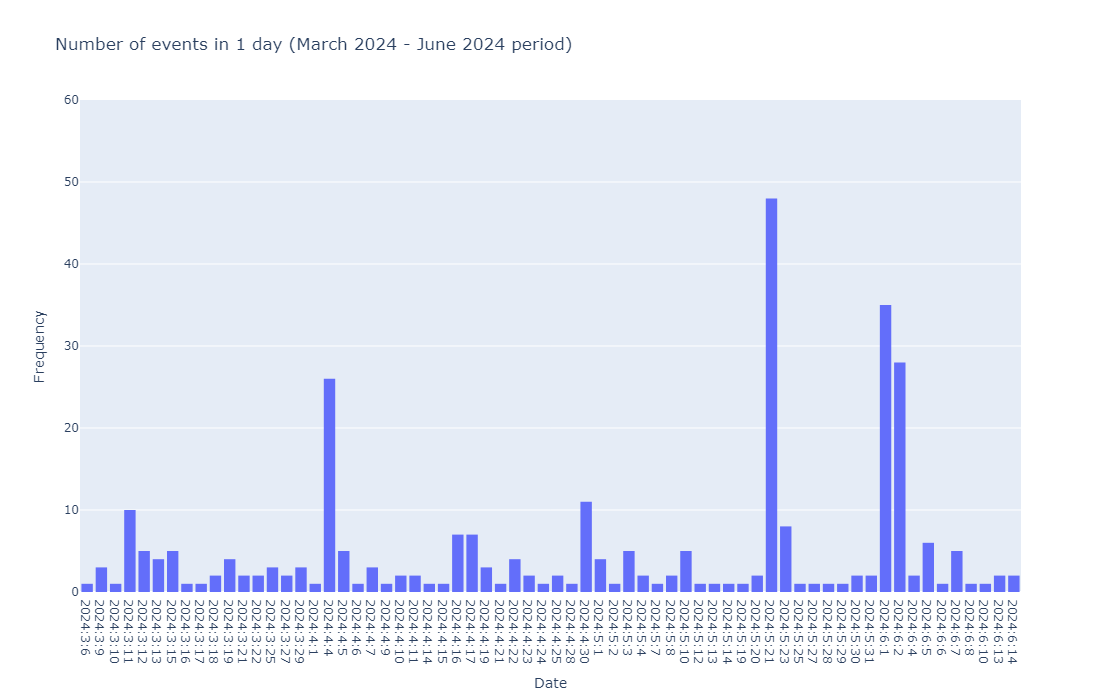

In [44]:
# group the events by the day
group = pd_nll.groupby(['Year', 'Month', 'Day']).size()
group_df = group.reset_index(name = 'Events')
group_df.Year = group_df.Year.astype(int);group_df.Month = group_df.Month.astype(int);group_df.Day = group_df.Day.astype(int)
group_df['Date'] = group_df.Year.astype(str) + ':' + group_df.Month.astype(str) + ':' + group_df.Day.astype(str)
group_df.head()
fig_group = go.Figure()
fig_group.add_trace(go.Histogram(histfunc = "sum", y= group_df.Events, x= group_df.Date, name = "Events per day"))
fig_group.update_layout(
    title = f"Number of events in 1 day (March 2024 - June 2024 period)",
    xaxis_title = f"Date",yaxis_title = f"Frequency",
    yaxis = dict(range= [0,60]), height = 700)

#### b. Plot the NLL hypocenter

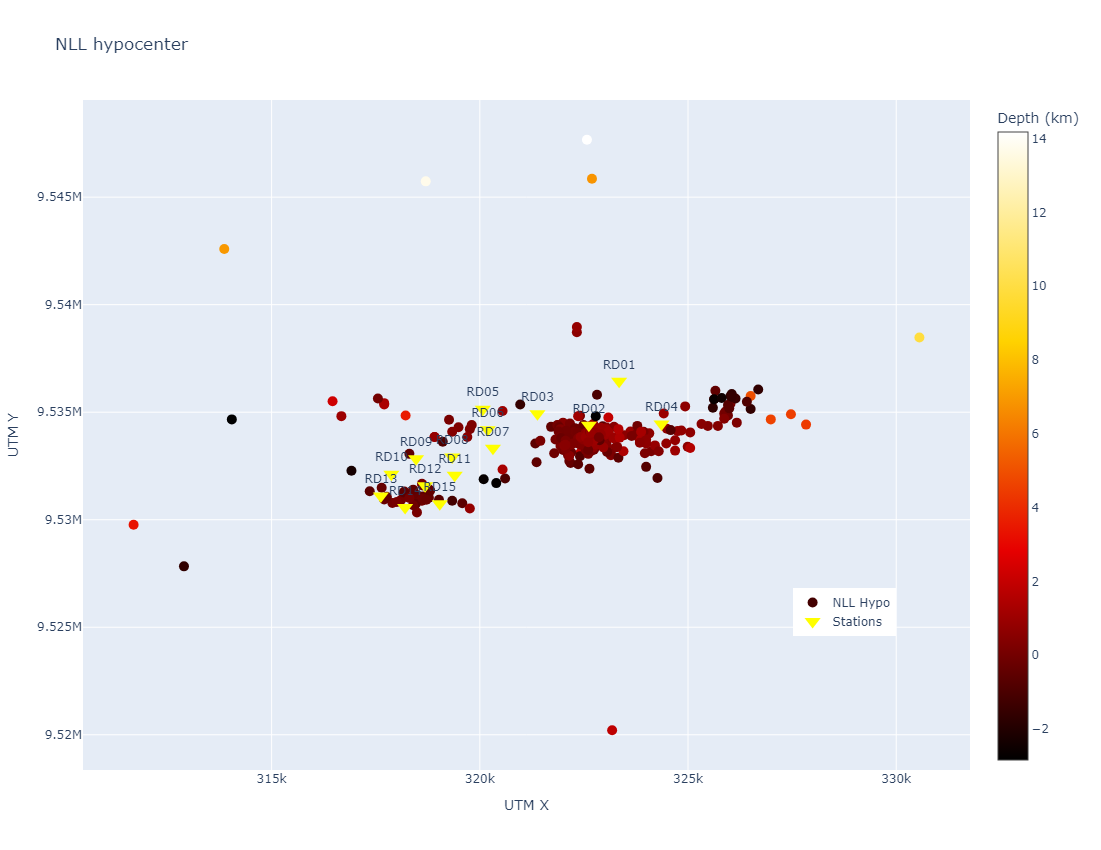

In [16]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x = x_nll, y = y_nll, mode='markers',marker=dict(size=10,  color=depth_nll,  
        colorscale='Hot',  
        colorbar=dict(title='Depth (km)')
        ), name = 'NLL Hypo'))
fig2.add_trace(go.Scatter(x =x_sta , y = y_sta, mode='markers+text',marker=dict(size=14,  color = 'Yellow', symbol = 'triangle-down'),
        name = 'Stations', text = sta_name, textposition = 'top center' ))
fig2.update_layout(
    title = f"NLL hypocenter ",
    xaxis_title = 'UTM X', yaxis_title = 'UTM Y',
    width = 850, height = 850,
    legend=dict(x=0.8, y=0.2,xanchor='left', yanchor='bottom'),
    coloraxis_colorbar=dict(title="Depth (km)"))

#### c. RMS error 

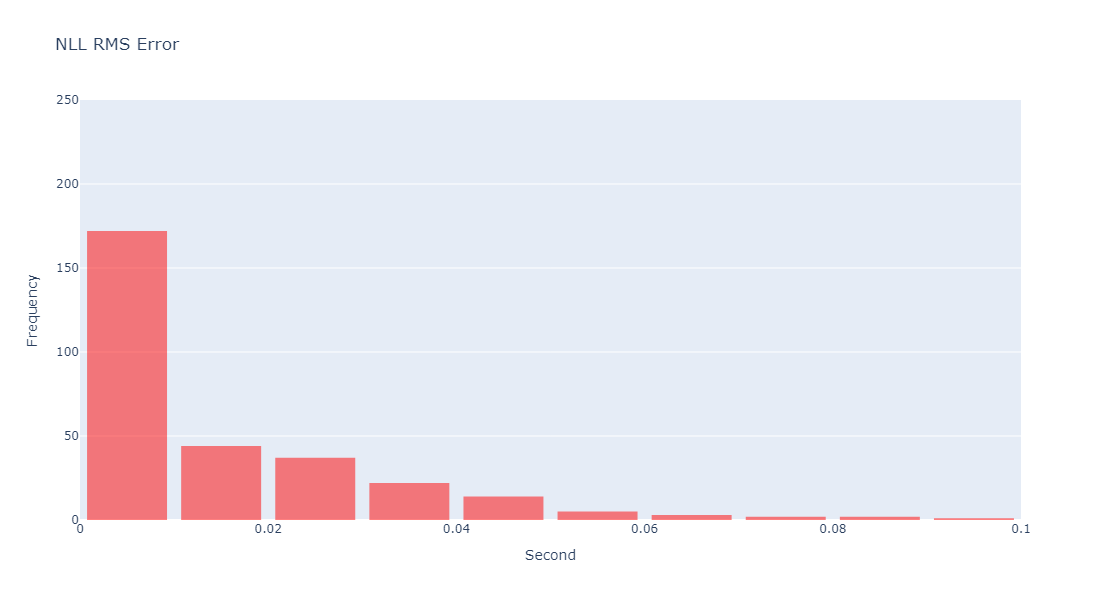

In [18]:
nll_error = pd_nll['RMS error']
bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
fig3 = go.Figure()
fig3.add_trace(go.Histogram(
    x = nll_error,
    xbins=dict(start=min(bins), end=max(bins),size=bins[1] - bins[0]),
    marker=dict(color='red', opacity = 0.5),
    ))
fig3.update_layout(
    title = f"NLL RMS Error",
    xaxis_title = 'Second', yaxis_title = 'Frequency',
    yaxis = dict(range= [0,250]),
    width = 800, height = 600, bargap = 0.15)

#### d. Spatial Error for Initial hypocenter

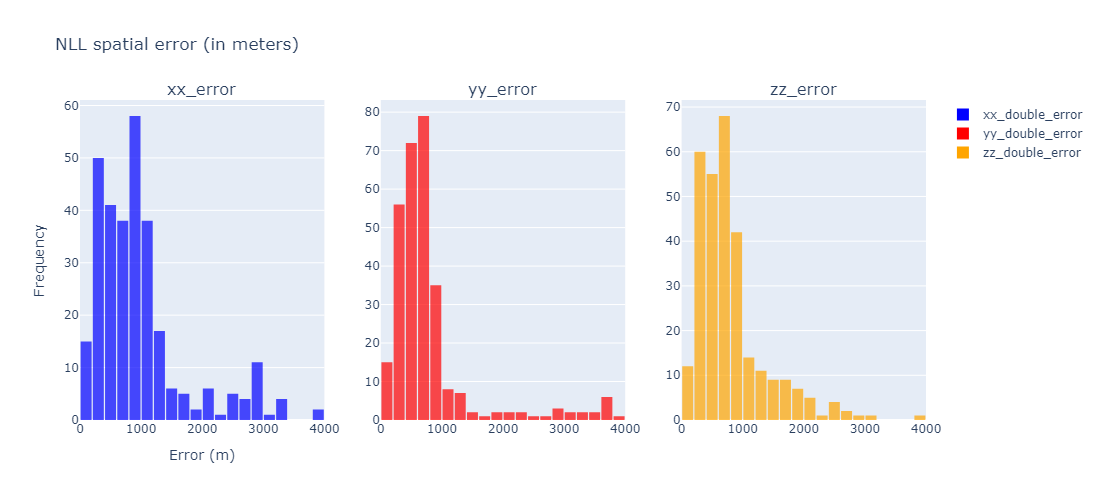

In [116]:
# create subplots
fig_spa = make_subplots(rows = 1, cols = 3, subplot_titles=("xx_error", "yy_error", "zz_error"))
# create the spatial error dataframe
xx_err = pd_nll['PDF errXX +/- (m)']; yy_err = pd_nll['PDF errYY +/- (m)']; zz_err = pd_nll['PDF errZZ +/- (m)']
bins = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000]
fig_spa.add_trace(go.Histogram(x = xx_err, xbins=dict(start=min(bins), end=max(bins),size=bins[1] - bins[0]),
    marker=dict(color='blue', opacity = 0.7), name = 'xx_double_error'), row = 1, col =1 )
fig_spa.add_trace(go.Histogram(x = yy_err, xbins=dict(start=min(bins), end=max(bins),size=bins[1] - bins[0]),
    marker=dict(color='red', opacity = 0.7), name = 'yy_double_error'), row = 1, col =2 )
fig_spa.add_trace(go.Histogram(x = zz_err, xbins=dict(start=min(bins), end=max(bins),size=bins[1] - bins[0]),
    marker=dict(color='orange', opacity = 0.7),name = 'zz_double_error'), row = 1, col =3 )
fig_spa.update_layout(title = f"NLL spatial error (in meters)", xaxis_title = 'Error (m)', yaxis_title = 'Frequency', height = 500, bargap = 0.1)

### 4. Relocated Hypocenter (HypoDD non WCC and with WCC)

#### a. Load and display the non WCC data

In [21]:
# load the data and initiate the plotting 
pd_nonWCC = pd.read_excel(raw_catalog, sheet_name = 'DD non WCC', header = 2)
x_nonWCC = pd_nonWCC['UTM X (m)']
y_nonWCC = pd_nonWCC['UTM Y (m)']
depth_nonWCC = pd_nonWCC['Depth (m)'] / 1000
pd_nonWCC.head(8)

ID       Lat         Lon    UTM X (m)    UTM Y (m)  Depth (m)  Elev (m)  \
0  2000 -4.242674  103.368750  318952.4648  9530857.741   -788.230   788.230   
1  2001 -4.203715  103.355745  317499.6231  9535162.851   1102.460 -1102.460   
2  2002 -4.202572  103.357170  317657.4765  9535289.544   1376.830 -1376.830   
3  2003 -4.206831  103.348315  316675.4030  9534816.532   1030.060 -1030.060   
4  2004 -4.233423  103.379041  320092.7420  9531883.065  -2730.357  2730.357   
5  2005 -4.239856  103.365397  318579.5785  9531168.551   -444.740   444.740   
6  2006 -4.240312  103.364697  318501.9948  9531118.018   -180.900   180.900   
7  2007 -4.238608  103.363102  318324.5129  9531306.007   -439.930   439.930   

   Year  Month  Day  Hour  Minute    OT(sec)  RMS error  Remarks  \
0  2024      3    6    12      49  46.520001   0.014298    Reloc   
1  2024      3    9    13       9  38.750000   0.006440    Reloc   
2  2024      3    9    13      10  42.229999   0.006440    Reloc   
3  2024      3    9    22      47  51.342703   0.023819  Initial   
4  2024      3   10     7      38  55.681969   0.022159  Initial   
5  2024      3   11    19      39  56.040001   0.011821    Reloc   
6  2024      3   11    19      40   4.780000   0.013556    Reloc   
7  2024      3   11    19      43   5.280000   0.013156    Reloc   

   Ml Magnitude  Mw Magnitude  
0      0.403903      0.101098  
1      1.001797      0.692220  
2      1.470677      0.950449  
3      0.550277      0.440897  
4           NaN           NaN  
5      0.866484      0.538911  
6      2.447147      1.658175  
7      0.896509      0.661829

#### b. Load and display the WCC data

In [23]:
# load the data and initiate the plotting 
pd_WCC = pd.read_excel(raw_catalog, sheet_name = 'DD with WCC', header = 2)
x_WCC = pd_WCC['UTM X (m)']
y_WCC = pd_WCC['UTM Y (m)']
depth_WCC = pd_WCC['Depth (m)'] / 1000
pd_WCC.head(8)

ID       Lat         Lon    UTM X (m)    UTM Y (m)  Depth (m)  Elev (m)  \
0  2000 -4.240986  103.375155  319663.0906  9531045.907   -914.950   914.950   
1  2001 -4.203372  103.355640  317487.7970  9535200.766   1057.610 -1057.610   
2  2002 -4.203128  103.358122  317763.3109  9535228.283   1465.720 -1465.720   
3  2003 -4.206831  103.348315  316675.4030  9534816.532   1030.060 -1030.060   
4  2004 -4.233423  103.379041  320092.7420  9531883.065  -2730.357  2730.357   
5  2005 -4.239546  103.363175  318332.8695  9531202.344   -287.910   287.910   
6  2006 -4.240368  103.362923  318305.0517  9531111.420   -168.080   168.080   
7  2007 -4.239715  103.364185  318444.9368  9531183.903   -181.160   181.160   

   Year  Month  Day  Hour  Minute    OT(sec)  RMS error  Remarks  \
0  2024      3    6    12      49  46.509998   0.000187    Reloc   
1  2024      3    9    13       9  38.779999   0.008434      WCC   
2  2024      3    9    13      10  42.220001   0.008434      WCC   
3  2024      3    9    22      47  51.342703   0.023819  Initial   
4  2024      3   10     7      38  55.681969   0.022159  Initial   
5  2024      3   11    19      39  56.080002   0.010025      WCC   
6  2024      3   11    19      40   4.760000   0.008181      WCC   
7  2024      3   11    19      43   5.400000   0.007809      WCC   

   Ml Magnitude  Mw Magnitude  
0      0.403903      0.101098  
1      1.001797      0.692220  
2      1.470677      0.950449  
3      0.550277      0.440897  
4           NaN           NaN  
5      0.866484      0.538911  
6      2.447147      1.658175  
7      0.896509      0.661829

#### c. Plot the NLL, non WCC and WCC hypocenter comparison

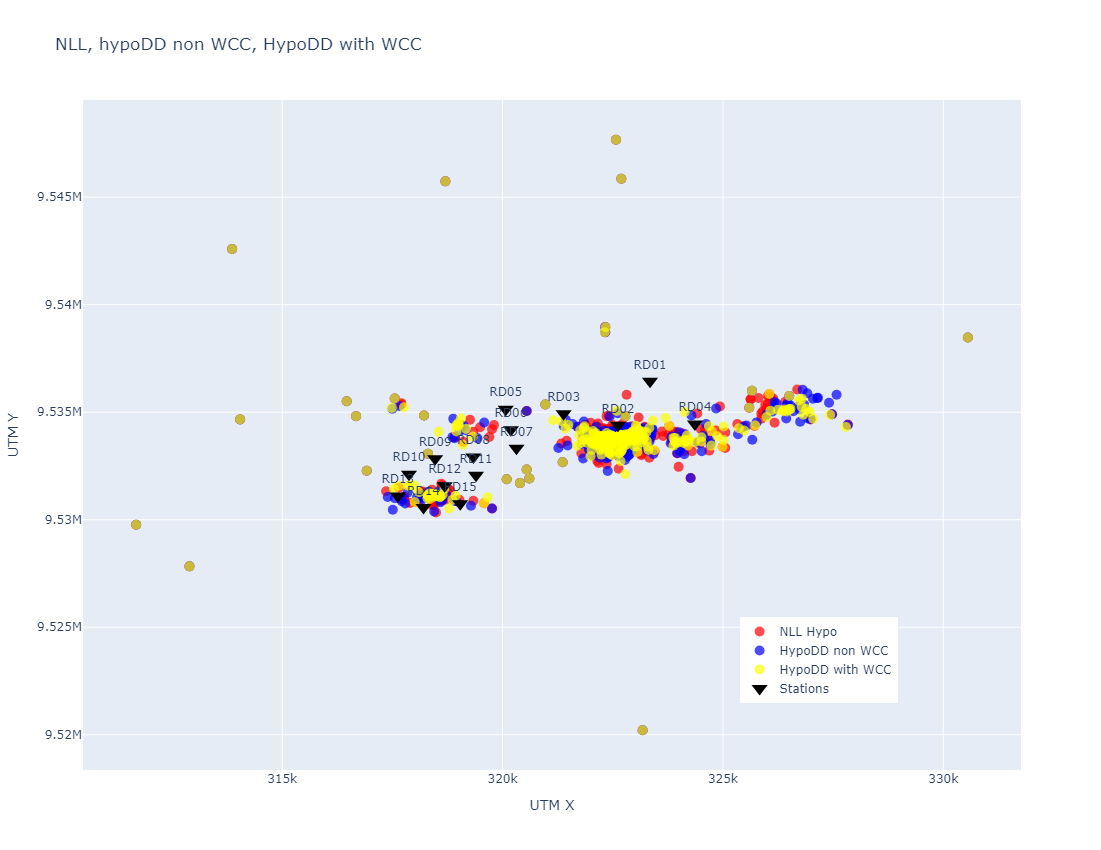

In [25]:
fig4 = go.Figure()

fig4.add_trace(go.Scatter(x = x_nll, y = y_nll, mode='markers',marker=dict(size=10,  color='Red'
        ,opacity = 0.7), name = 'NLL Hypo'))
fig4.add_trace(go.Scatter(x = x_nonWCC, y = y_nonWCC, mode='markers',marker=dict(size=10,  color='Blue'
        , opacity = 0.7), name = 'HypoDD non WCC'))
fig4.add_trace(go.Scatter(x = x_WCC, y = y_WCC, mode='markers',marker=dict(size=10,  color='Yellow'
        , opacity = 0.7), name = 'HypoDD with WCC'))

fig4.add_trace(go.Scatter(x =x_sta , y = y_sta, mode='markers+text',marker=dict(size=14,  color = 'Black', symbol = 'triangle-down'),
        name = 'Stations', text = sta_name, textposition = 'top center' ))
fig4.update_layout(
    title = f"NLL, hypoDD non WCC, HypoDD with WCC",
    xaxis_title = 'UTM X', yaxis_title = 'UTM Y',
    width = 850, height = 850,
    legend=dict(x=0.7, y=0.1,xanchor='left', yanchor='bottom'),
    coloraxis_colorbar=dict(title="Depth (km)"))

#### d. RMS error comparison

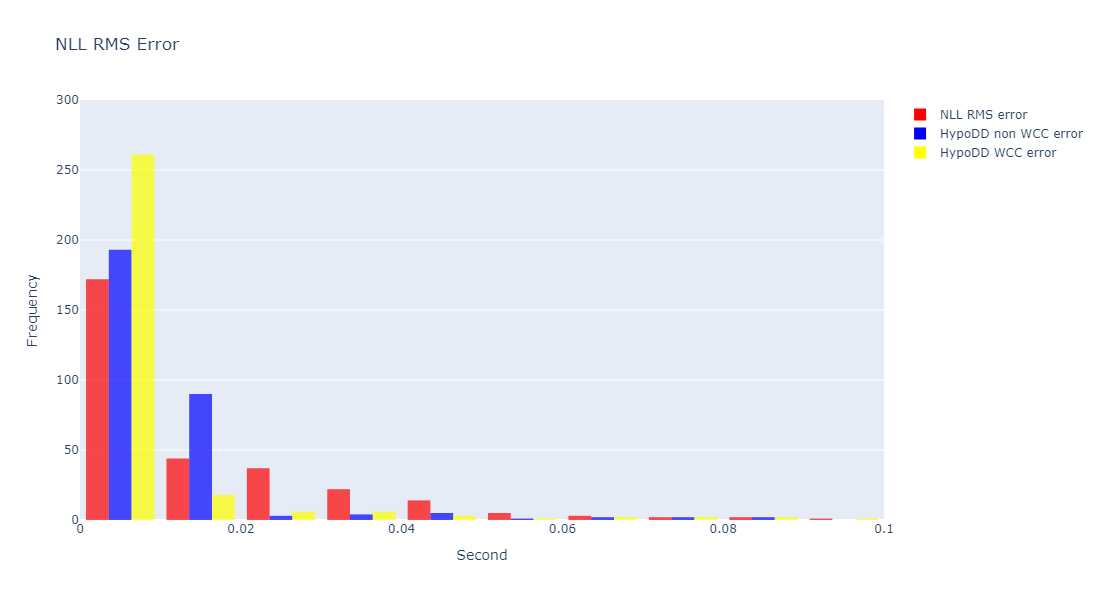

In [27]:
# Load the data
nll_error = pd_nll['RMS error']
hypoDD_nonWCC_error = pd_nonWCC['RMS error']
hypoDD_WCC_error = pd_WCC['RMS error']
bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
fig5 = go.Figure()
fig5.add_trace(go.Histogram(
    x = nll_error, xbins=dict(start=min(bins), end=max(bins),size=bins[1] - bins[0]),
    marker=dict(color='red', opacity = 0.7), name = 'NLL RMS error'
    ))
fig5.add_trace(go.Histogram(
    x = hypoDD_nonWCC_error, xbins=dict(start=min(bins), end=max(bins),size=bins[1] - bins[0]),
    marker=dict(color='blue', opacity = 0.7), name = 'HypoDD non WCC error'
    ))
fig5.add_trace(go.Histogram(
    x = hypoDD_WCC_error, xbins=dict(start=min(bins), end=max(bins),size=bins[1] - bins[0]),
    marker=dict(color='yellow', opacity = 0.7), name = 'HypoDD WCC error'
    ))
fig5.update_layout(
    title = f"NLL RMS Error",
    xaxis_title = 'Second', yaxis_title = 'Frequency',
    yaxis = dict(range= [0,300]),
    width = 800, height = 600, bargap = 0.15)
fig5.show()

#### e. Plot final hypocenter (HypoDD with WCC)

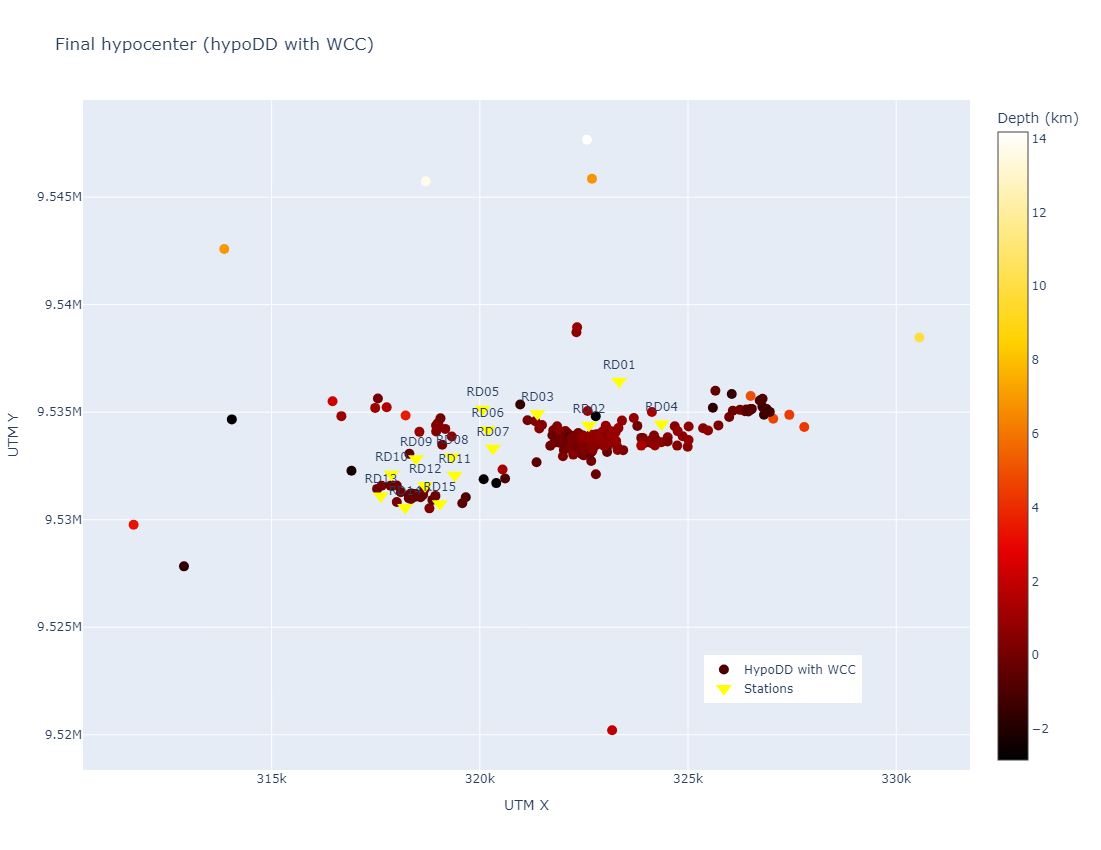

In [29]:
fig6 = go.Figure()
fig6.add_trace(go.Scatter(x = x_WCC, y = y_WCC, mode='markers',marker=dict(size=10,  color= depth_WCC,
        colorscale='Hot',  
        colorbar=dict(title='Depth (km)')), name = 'HypoDD with WCC'))
fig6.add_trace(go.Scatter(x =x_sta , y = y_sta, mode='markers+text',marker=dict(size=14,  color = 'Yellow', symbol = 'triangle-down'),
        name = 'Stations', text = sta_name, textposition = 'top center' ))
fig6.update_layout(
    title = f"Final hypocenter (hypoDD with WCC)",
    xaxis_title = 'UTM X', yaxis_title = 'UTM Y',
    width = 850, height = 850,
    legend=dict(x=0.7, y=0.1,xanchor='left', yanchor='bottom'),
    coloraxis_colorbar=dict(title="Depth (km)"))
fig6.show()